In [1]:
!pip install tensorflow matplotlib

   ---------------------------------------- 0.0/375.7 MB ? eta -:--:--
   ---------------------------------------- 1.0/375.7 MB 6.3 MB/s eta 0:01:00
   ---------------------------------------- 2.4/375.7 MB 6.1 MB/s eta 0:01:02
   ---------------------------------------- 3.4/375.7 MB 5.9 MB/s eta 0:01:03
    --------------------------------------- 4.7/375.7 MB 5.9 MB/s eta 0:01:03
    --------------------------------------- 5.8/375.7 MB 5.8 MB/s eta 0:01:05
    --------------------------------------- 6.8/375.7 MB 5.8 MB/s eta 0:01:04
    --------------------------------------- 8.1/375.7 MB 5.9 MB/s eta 0:01:03
   - -------------------------------------- 9.4/375.7 MB 5.8 MB/s eta 0:01:03
   - -------------------------------------- 10.2/375.7 MB 5.7 MB/s eta 0:01:05
   - -------------------------------------- 11.5/375.7 MB 5.7 MB/s eta 0:01:04
   - -------------------------------------- 12.8/375.7 MB 5.8 MB/s eta 0:01:03
   - -------------------------------------- 14.2/375.7 MB 5.8 MB/s e

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

Загрузка данных

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step 
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Нормализация данных 

In [4]:
x_train = x_train / 255.0
x_test = x_test / 255.0

Добавление размерности канала

In [5]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 30
noise_dim = 100  
num_examples_to_generate = 16  

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Генератор

In [8]:
def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

Дискриминатор

In [9]:
def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(1))
    
    return model

In [10]:
generator = make_generator_model()
discriminator = make_discriminator_model()

C:\ProgramData\anaconda3\envs\yyy\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\ProgramData\anaconda3\envs\yyy\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
cross_entropy = BinaryCrossentropy(from_logits=True)

In [12]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(5e-5)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [15]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [16]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [17]:
def train(dataset, epochs):
    history = []
    
    for epoch in range(epochs):
        gen_loss_epoch = 0
        disc_loss_epoch = 0
        num_batches = 0
        
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += gen_loss
            disc_loss_epoch += disc_loss
            num_batches += 1
        
        gen_loss_epoch /= num_batches
        disc_loss_epoch /= num_batches
        
        history.append((gen_loss_epoch, disc_loss_epoch))
        
        # Генерация изображений каждые 10 эпох
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)
        
        print(f'Epoch {epoch + 1}/{epochs}, Gen Loss: {gen_loss_epoch:.4f}, Disc Loss: {disc_loss_epoch:.4f}')
    
    return history

Обучение

Epoch 1/30, Gen Loss: 0.8007, Disc Loss: 1.3235
Epoch 2/30, Gen Loss: 0.7075, Disc Loss: 1.4001
Epoch 3/30, Gen Loss: 0.6545, Disc Loss: 1.3938
Epoch 4/30, Gen Loss: 0.6798, Disc Loss: 1.3800
Epoch 5/30, Gen Loss: 0.6723, Disc Loss: 1.3705
Epoch 6/30, Gen Loss: 0.6868, Disc Loss: 1.3603
Epoch 7/30, Gen Loss: 0.7045, Disc Loss: 1.3629
Epoch 8/30, Gen Loss: 0.6970, Disc Loss: 1.3688
Epoch 9/30, Gen Loss: 0.7156, Disc Loss: 1.3535


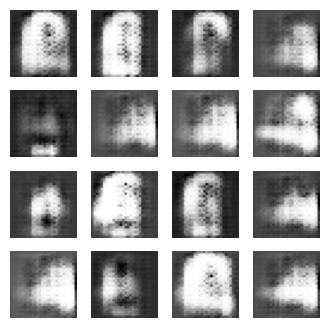

Epoch 10/30, Gen Loss: 0.7225, Disc Loss: 1.3347
Epoch 11/30, Gen Loss: 0.7472, Disc Loss: 1.3267
Epoch 12/30, Gen Loss: 0.7777, Disc Loss: 1.2868
Epoch 13/30, Gen Loss: 0.7894, Disc Loss: 1.2672
Epoch 14/30, Gen Loss: 0.7963, Disc Loss: 1.2477
Epoch 15/30, Gen Loss: 0.8447, Disc Loss: 1.2061
Epoch 16/30, Gen Loss: 0.8831, Disc Loss: 1.1784
Epoch 17/30, Gen Loss: 0.8999, Disc Loss: 1.1484
Epoch 18/30, Gen Loss: 0.9874, Disc Loss: 1.0748
Epoch 19/30, Gen Loss: 1.0203, Disc Loss: 1.0569


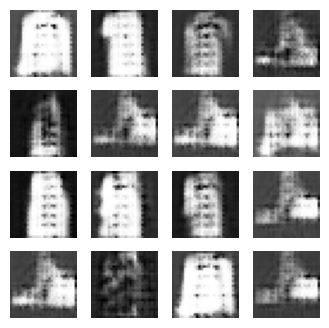

Epoch 20/30, Gen Loss: 1.0885, Disc Loss: 1.0148
Epoch 21/30, Gen Loss: 1.0923, Disc Loss: 1.0004
Epoch 22/30, Gen Loss: 1.0425, Disc Loss: 1.0412
Epoch 23/30, Gen Loss: 1.0578, Disc Loss: 1.0478
Epoch 24/30, Gen Loss: 1.0425, Disc Loss: 1.0667
Epoch 25/30, Gen Loss: 1.0638, Disc Loss: 1.0548
Epoch 26/30, Gen Loss: 1.0461, Disc Loss: 1.0788
Epoch 27/30, Gen Loss: 1.0565, Disc Loss: 1.0722
Epoch 28/30, Gen Loss: 1.0566, Disc Loss: 1.0694
Epoch 29/30, Gen Loss: 1.0460, Disc Loss: 1.0856


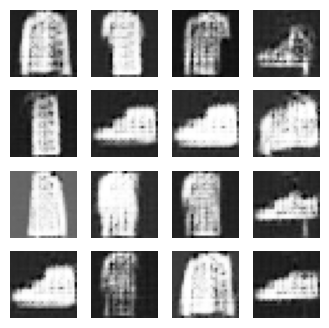

Epoch 30/30, Gen Loss: 1.0514, Disc Loss: 1.0917


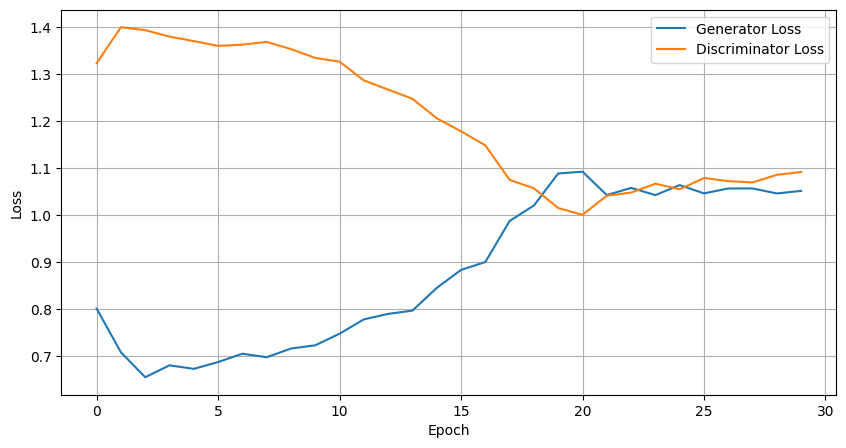

In [18]:
history = train(train_dataset, EPOCHS)
plt.figure(figsize=(10, 5))
plt.plot([h[0] for h in history], label='Generator Loss')
plt.plot([h[1] for h in history], label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

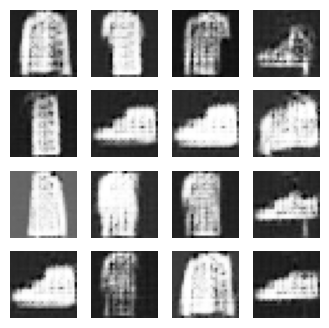

In [19]:
generate_and_save_images(generator, EPOCHS, seed)